# Results

*Team: nada401*

In this Notebook we present the initial results of our project.

Structure:
- Data cleaning and exploration
    - Language tagging
    - Data cleaning
    - Data exploration
- Expert-metric
    - Ad-hoc metric
    - Language depth
    - Embeddings

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Reproducibility

To reproduce the results of this notebook first download the datasets from [here](https://drive.google.com/drive/folders/1Wz6D2FM25ydFw_-41I9uTwG9uNsN4TCF) and unzip them in `./data/`.

Only the datasets
- `RateBeer`
- `BeerAdvocate`

are used for this part of the project.

### Notation

To distinguish the two datasets, a common naming scheme has been used, in particular:
- `*_RB` contains data from RateBeer
- `*_BA` contains data from BeerAdvocate

## Data cleaning and exploration

The first step into developing this project is cleaning and exploring the data.

### Language tagging

A first manual analysis of the datasets revealed that some reviews have been written in different languages, so we first wanted to understand the share of each language to direct our successive steps.

To achieve this, we tested different python packages that tag language, among which:
- [fast_langdetect](https://github.com/LlmKira/fast-langdetect)
- [langdetect](https://pypi.org/project/langdetect/)
- [lingua](https://github.com/pemistahl/lingua-py)

Finally opting for the first, being the fastest and having good precision.

In [ ]:
from src.scripts.lang_tagger import lang_tagger

'''
Execute the language tagging process.
This function calls the pipeline that reads the .txt.gz files and creates a .csv file
with only the reviews and few other columns for indexing purposes.
'''
lang_tagger.tag_datasets()

In [ ]:
d_BA = pd.read_csv("./data/BeerAdvocate/reviews_tagged.csv")
d_RB = pd.read_csv("./data/RateBeer/reviews_tagged.csv")

eng_perc_BA = d_BA["lang_tag"].value_counts()['en']/d_BA["lang_tag"].count() * 100
eng_perc_RB = d_RB["lang_tag"].value_counts()['en']/d_RB["lang_tag"].count() * 100

print(f"Percentage of English reviews in BeerAdvocate = {eng_perc_BA:.3f}%")
print(f"Percentage of English reviews in RateBeer = {eng_perc_RB:.3f}%")

print(f"\nNumber of reviews for the first 5 most used languages in RateBeer. Only the first 5 shown for visualization purposes")
print(f"{d_RB['lang_tag'].value_counts()[:5]}")

The majority of reviews are made in English, especially in BeerAdvocate. 
We therefore initially focus on solely English reviews, specifically the one in BeerAdvocate, but we plan later in the development of the project to work also on RateBeer and we to test our metrics on different languages as well.

In [ ]:
# Free memory after showing the results
del d_BA, d_RB

### Data cleaning

The dataset contained various NaN values and duplicated rows, all of which must be properly handled to ensure a correct analysis.

In [ ]:
from src.scripts.data_cleaning import data_cleaning, load_file

'''
Load the datasets and clean them. In particular:
- drop duplicates
- treat NaNs
- delete beers that don't have reviews
- delete users that didn't review at least one beer
- add language_tag column to the datasets
'''
data_cleaning.clean_data('./data')

In [ ]:
 # Issues with users.csv
df_users_RB = pd.read_csv('./data/RateBeer/users.csv')
df_users_RB_clean = pd.read_csv('./data/RateBeer/users_RB_clean.csv')

print(f"Are users_id in BeerAdvocate's user dataframe unique? {df_users_RB['user_id'].is_unique}")
print(f"By removing users that never did written reviews we dropped {df_users_RB.shape[0] - df_users_RB_clean.shape[0]} rows")
print(f"Rows before cleaning: {df_users_RB.shape[0]}\nRows after cleaning:  {df_users_RB_clean.shape[0]}")

In [ ]:
# language tagging and formatting
df_ratings_BA_clean = pd.read_csv('./data/BeerAdvocate/ratings_BA_clean.csv', nrows=5)
df_ratings_BA_clean.head()

In [ ]:
# Free memory after showing the results
del df_users_RB, df_users_RB_clean, df_ratings_BA_clean

### Data exploration

**TODO**

In [ ]:
# Vik's code

## Expert metric

The vast majority of the work done in Milestone 2 for the project has been finding a good "Expert metric" and checking that our assumptions are correct.

We needed a "Expert metric" that was reliable enough to see how written reviews change over time. This score should highlight the expertise and the precision of a review.

We tried different methods to get this metric:
- language depth
- embeddings
- ad-hoc metric

The first two didn't provide a significant score, while a "ad-hoc metric" proved to satisfy our needs. We therefore start by discussing this method.

### Ad-hoc metric

Due to the failure of previous general metrics, we tried creating a topic-specific metric that focuses solely on beer reviews.<br>

The goal is to develop a domain-specific metric. In this initial implementation, we define several key categories: flavor, aroma, mouthfeel, brewing, technical aspects, appearance, judgment, off-flavors, and miscellaneous. Each category contains specific terms relevant to beer evaluation. For every occurrence of these terms in a review, we add a point to the respective category score. The overall "expertness" score is calculated as the sum of these category scores. To account for the fact that different beers may have varying average scores due to distinct flavor profiles, each score is normalized using the mean and standard deviation of scores for the specific beer being reviewed. This approach aims to establish a consistent and meaningful metric that reflects the depth and expertise conveyed in beer reviews.

For this part, we will only use BeerAdvocate's dataframe

In [2]:
from src.scripts.expert_metric import expert_metric
from src.scripts.expert_metric import expert_analysis
from scipy.stats import pearsonr


data_folder = './data'

In [ ]:
expert_metric.add_ex_score_BA(data_folder)

In [3]:
data_folder = './data'

rev_with_scores, beers, users = expert_analysis.get_expert_metric_dfs(data_folder)

A first assumption made is that with time, a user gets more experience and therefore can understand and describe better characteristics of the beers he reviews. This is shown by the positive correlation between time and our metric score.

In [4]:
user_corr = expert_analysis.parse_users(rev_with_scores)

# Correlation between the expertness score and the number of reviews made for all users
corr_all_users = pearsonr(user_corr['expertness_score'], user_corr['nbr_rev'])
# Correlation only for users that made less than 200 reviews
user_corr_less_200 = user_corr[user_corr['nbr_rev']<200]
corr_less_200_rev = pearsonr(user_corr_less_200['expertness_score'], user_corr_less_200['nbr_rev'])

print(f"Correlation between the expertness score and the number of reviews made for all users\n{corr_all_users}\n")
print(f"Correlation only for users that made less than 200 reviews\n{corr_less_200_rev}")

Correlation between the expertness score and the number of reviews made for all users
PearsonRResult(statistic=0.19585266685946312, pvalue=0.0)

Correlation only for users that made less than 200 reviews
PearsonRResult(statistic=0.25250688377961705, pvalue=0.0)


From those correlations, it seems that people with less reviews tent to improve (i.e. higher positive correlation) more than people who do more reviews.<br>
A further analysis revealed how for an expert the metric changes over time.

Text(0.5, 1.0, 'Expertness Score Over Time')

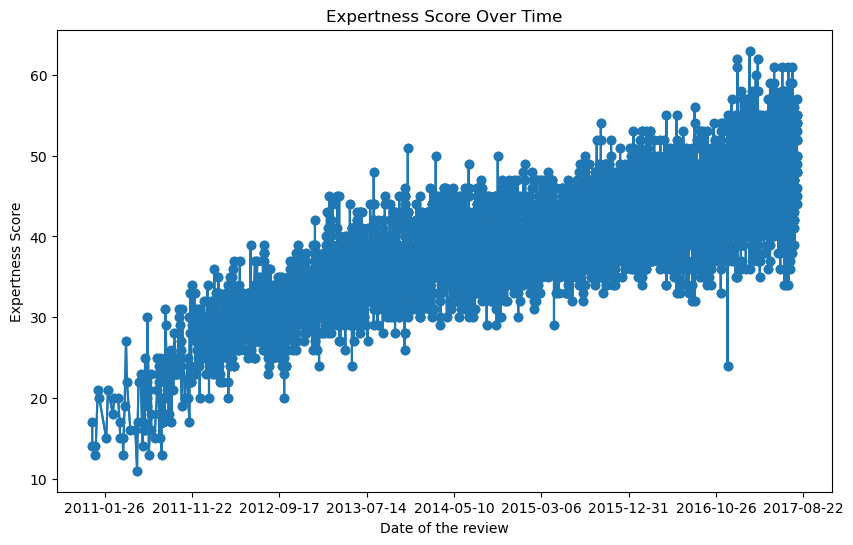

In [5]:
# Pick specific example
rev_of_exp = rev_with_scores[( rev_with_scores['user_id'] =='superspak.456300')]

rev_of_exp = expert_metric.score_df(rev_of_exp)
sorted_data = rev_of_exp.sort_values(by='date', ascending=True)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(sorted_data['date'], sorted_data['expertness_score'], marker='o', color="#1f77b4")
ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=10))
ax.set_xlabel("Date of the review")
ax.set_ylabel("Expertness Score")
ax.set_title("Expertness Score Over Time")

This particular example shows that our assumption can be true for some users.

We therefore focused on people that made a significant amount of reviews, i.e. at least 200, and tried to understand if such assumptions holds for a larger sample of users.

We start by showing that the first reviews that a user makes, tend to have a lower expertise score than average.<br>
To achieve this, we standardize the expert scores per beer.

In [6]:
col_to_keep = ['flavor', 'aroma', 'mouthfeel', 'brewing', 'technical', 'appearance', 'judgment','off_flavors', 'miscellaneous', 'expertness_score']

scores_for_beer = expert_analysis.get_scores_for_beer(rev_with_scores, col_to_keep)

/home/nicola_stocco/Documents/Università/ETH/3rd Semester/ADA/ada-2024-project-nada401/src/scripts/expert_metric/expert_analysis.py:83: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  y_copy = y.drop(columns=['review_count'])


Text(0.5, 1.0, 'Mean of the score (standardized) of the first 5 reviews of people with more than 200 reviews')

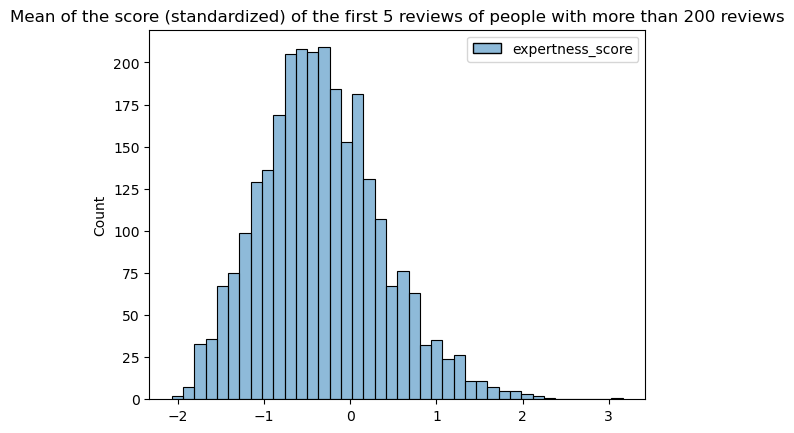

In [ ]:
# Consider the first 5 reviews of people who did at least 200 reviews
rev_of_exp = expert_analysis.review_of_experts(rev_with_scores, users, nbr_rev=200)
rev_of_exp = expert_analysis.first_reviews(rev_of_exp, max=5)

# Standardize the expertise score on a per-beer basis
rev_exp_std = expert_analysis.standardize(rev_of_exp, scores_for_beer.reset_index(), col_to_keep)
rev_exp_std_grouped = rev_exp_std.groupby('user_id')[['expertness_score']].agg('mean')

# Plot results
sns.histplot(rev_exp_std_grouped)
plt.title('Mean of the score (standardized) of the first 5 reviews of people with more than 200 reviews')

# Consider as not already experts the users which have low scores on their first reviews 
no_already_experts = rev_exp_std_grouped[rev_exp_std_grouped['expertness_score']<-0.5].index

We now graphically show the correlation between the expert metric and the number of reviews that a user did. A positive correlation corresponds to an improvement over time of the expertise in the reviews that a user make.

In [ ]:
# Consider the first 100 reviews of people who did at least 200 reviews
rev_of_exp = expert_analysis.review_of_experts(rev_with_scores, users, nbr_rev=200)
rev_of_exp = expert_analysis.first_reviews(rev_of_exp, max=100)

rev_exp_std = expert_analysis.standardize(rev_of_exp, scores_for_beer.reset_index(), col_to_keep)
result_rep_date = rev_exp_std.groupby('user_id').apply(lambda group: expert_analysis.corr_and_count(group, replace_date=True), include_groups=False)
result_rep_date = result_rep_date.dropna()

/home/nicola_stocco/Documents/Università/ETH/3rd Semester/ADA/ada-2024-project-nada401/src/scripts/expert_metric/expert_analysis.py:83: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  y_copy = y.drop(columns=['review_count'])


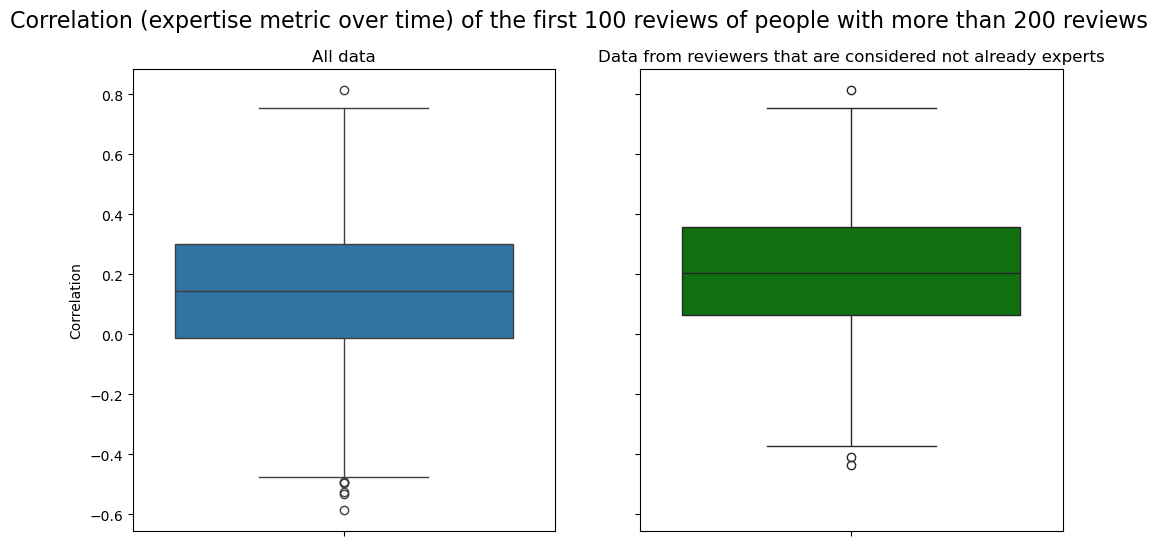

In [13]:
# Plot results
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey = True) 
fig.suptitle("Correlation (expertise metric over time) of the first 100 reviews of people with more than 200 reviews \n", fontsize=16)
sns.boxplot(y=result_rep_date['correlation'], ax=axes[0])
axes[0].set_title("All data")
axes[0].set_ylabel("Correlation")

sns.boxplot(y=result_rep_date[result_rep_date.index.isin(no_already_experts)]['correlation'], ax=axes[1], color = 'green')
axes[1].set_title("Data from reviewers that are considered not already experts")
plt.show()

This shows that reviewers with a lower then average score on their first reviews tend to improve in the next reviews.

### Language depth

The assumption for this method was that a reviewers with more expertise would utilize a more nuanced vocabulary in their reviews.

To extract language depth of a review we used
[LexicalRichness](https://github.com/LSYS/LexicalRichness),
a python package that extracts some metrics highlighting language richness of a text.<br>
This has been used to evaluate each written reviews.

However, the subsequent analysis yielded unsatisfactory results. We believe this is because language richness does not directly correlate with higher-quality reviews, as the metrics extrapolated by the package are not specifically tailored to reviews or beer.

### Embeddings

We also tried with finding the embeddings of the reviews and trying to see if such a method could be used as an expertise metric.<br>
To find the embeddings we used:
- [all-mpnet-base-v2](https://huggingface.co/sentence-transformers/all-mpnet-base-v2) 

This model maps paragraphs to a 768 dimensional dense vector space, that we then visualize by projecting it in a 2D space with t-SNE and PCA.

While some interesting patterns have been observed, it is clear that embeddings can't be used as a metric score.<br>